# Moving Beyond Linearity

In [38]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_validate
from sklearn.feature_selection import f_classif
import statsmodels.api as sm

**1. In this exercise, you will further analyze the Wage data set**

*(a) Perform polynomial regression to predict wage using age. Use cross-validation to select the optimal degree d for the polynomial. What degree was chosen, and how does this compare to the results of hypothesis testing using ANOVA? Make a plot of the resulting polynomial fit to the data.*

In [3]:
wage_df = pd.read_csv(r'C:\Users\caine\OneDrive\Documents\statistical_learning_problems\0 datasets\Wage.csv')
wage_df.head()

,Unnamed: 0,year,age,sex,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,231655,2006,18,1. Male,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,86582,2004,24,1. Male,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,161300,2003,45,1. Male,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
3,155159,2003,43,1. Male,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
4,11443,2005,50,1. Male,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154


To tackle this question we will first extract the response variable, wage, and the independent variable age. We will then transform the age vector into a matrix with each additional column representing the next polynomial of age. 

Using sklearn's `KFold` class and the `cross_validate` function we will perform cross validation and plot it on a chart. This will allow us to select the optimal degree for the polynomial. Once the optimal degree has been chosen we will fit a polynomial regression model with the selected degree and plot the fitted curve and the data.

The question also asks to compare this with the results of hypothesis testing using ANOVA. An ANOVA test is usually conducted to test if differences in the mean of different groups are statistically significant. In this context, the ANOVA can be used to test whether adding higher degree polynomial terms results in a statistically significant reduction in the model error.

In [4]:
wage = wage_df['wage'].to_numpy()
age = wage_df['age'].to_numpy()

In [5]:
age

array([18, 24, 45, ..., 27, 27, 55], dtype=int64)

In [6]:
powers = np.arange(1, 10, 1).reshape(9, 1)
age_pows = age ** powers
age_pows

array([[              18,               24,               45, ...,
                      27,               27,               55],
       [             324,              576,             2025, ...,
                     729,              729,             3025],
       [            5832,            13824,            91125, ...,
                   19683,            19683,           166375],
       ...,
       [       612220032,       4586471424,     373669453125, ...,
             10460353203,      10460353203,    1522435234375],
       [     11019960576,     110075314176,   16815125390625, ...,
            282429536481,     282429536481,   83733937890625],
       [    198359290368,    2641807540224,  756680642578125, ...,
           7625597484987,    7625597484987, 4605366583984375]],
      dtype=int64)

In [7]:
age_pows[0:2, :]

array([[  18,   24,   45, ...,   27,   27,   55],
       [ 324,  576, 2025, ...,  729,  729, 3025]], dtype=int64)

In [8]:
wage.shape

(3000,)

In [9]:
k_fold = KFold(n_splits=5)

In [10]:
polynomials = []
cv_scores = []
for i in range(1, len(powers)+1):
    cv_results = cross_validate(estimator=LinearRegression(), X=age_pows.T[:, 0:i], y=wage, cv=k_fold, scoring='neg_mean_squared_error',)
    polynomials.append(i)
    cv_scores.append(cv_results['test_score'].mean() * -1)

cv_scores


[1675.0142380530044,
 1599.5982268539042,
 1594.7262162596164,
 1593.9141039099823,
 1595.4331311683372,
 1594.930289697439,
 1598.953359191816,
 1599.4419183478265,
 1599.4245417477928]

From the chart below we can see that the MSE is minimised at degree 4. However, there is little difference between 2 and 4 and so we opt for the simpler model.

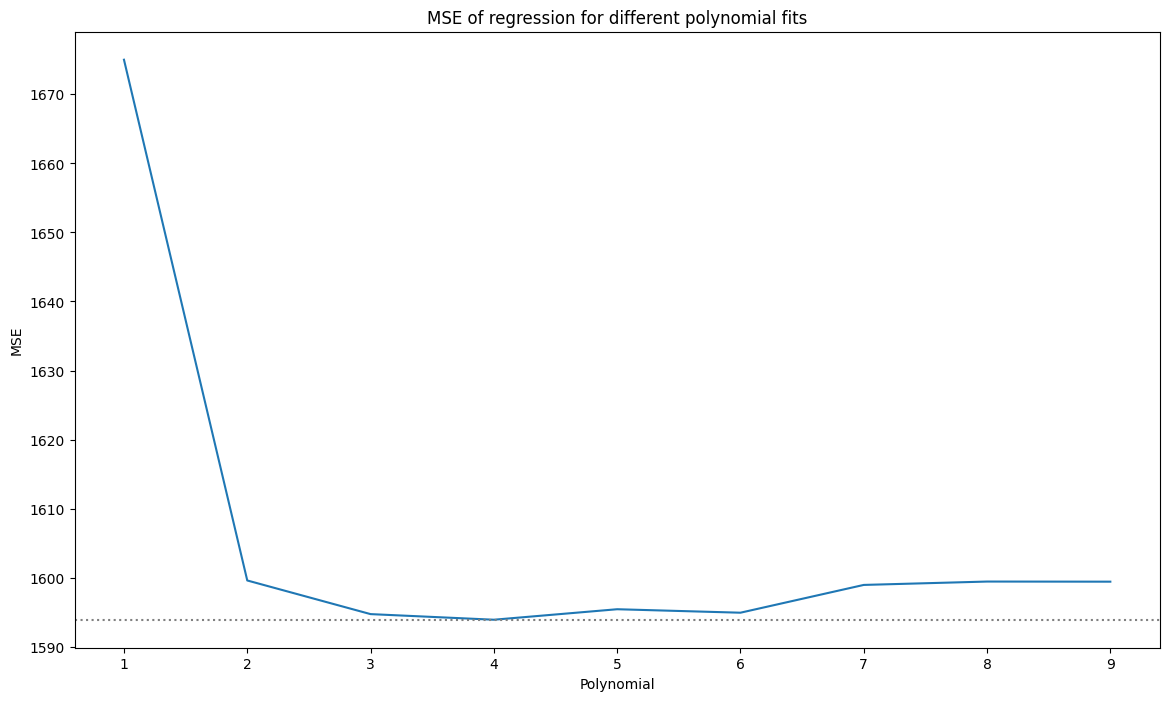

In [11]:
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot()
ax.plot(polynomials, cv_scores)
ax.set_title('MSE of regression for different polynomial fits')
ax.set_xlabel('Polynomial')
ax.set_ylabel('MSE')
ax.axhline(min(cv_scores), ls=':', c='grey')

In [12]:
polynomial_age_model = LinearRegression()
polynomial_age_model.fit(age_pows.T[:, 0:2], wage)

LinearRegression()

In [13]:
polynomial_age_model.coef_

array([ 5.29403003, -0.05300507])

In [14]:
age_range = np.arange(min(age), max(age), 1)
wage_preds = (age_range*polynomial_age_model.coef_[0]) + (age_range**2 *polynomial_age_model.coef_[1])

Below is the plot of the data and fitted polynomial regression model. A model with a polynomial of degree 2 seems to capture one aspect of how age influences wage. There is clearly a tendency for wages to rise as age increases and then after around 50 start to fall again. However, there seems to be a group of ultra high earners where age is not an influence on their wage.

Text(0, 0.5, 'Wage')

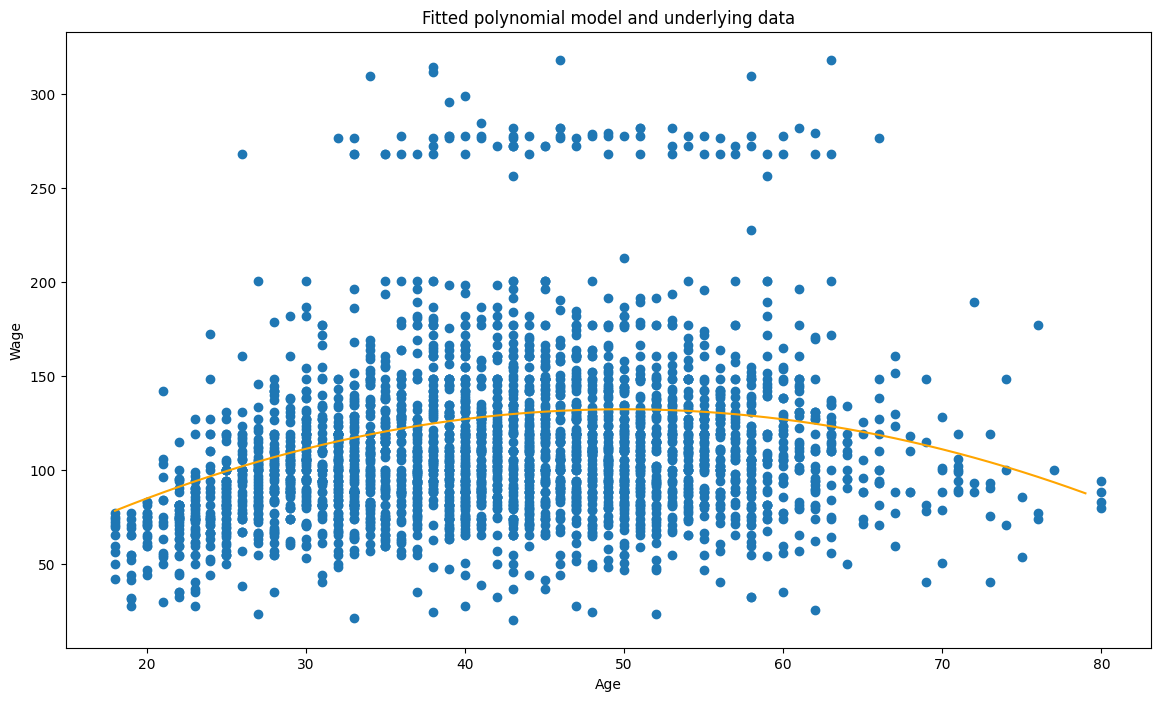

In [15]:
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot()
ax.scatter(age, wage)
ax.plot(age_range, wage_preds, c='orange')

ax.set_title('Fitted polynomial model and underlying data')
ax.set_xlabel('Age')
ax.set_ylabel('Wage')


Now we will use the ANOVA test to test if higher order polynomials results in a better fit. We have the following hypotheses:

$$
H_{0} : error_{d1} = error_{d2}
$$

$$
H_{1} : error_{d1} \gt error_{d2} 
$$

That is, the null hypothesis is the residual model error is the same for first and second order degree polynomial models. The alternative is that the model error is reduced when we include a second order polynomial.

To do this we simply use the `f_classif` function provided by sklearn, we pass the predictors and the response and it returns the F-score for each predictor along with the p-values. We can see the p-value for both the first order and second order degree polynomials suggest that these predictors lead to a statistically significant reduction in the residual error, however when we get to the thrid order polynomial we have a p-value of 0.086 which is above our threshold.



In [43]:
anova_test_result = f_classif(age_pows.T[:, 0:3], wage)
anova_test_result

(array([1.38213737, 1.22039817, 1.09645624]),
 array([5.34695162e-07, 1.49487217e-03, 8.61364030e-02]))

*(b) Fit a step function to predict wage using age, and perform crossvalidation to choose the optimal number of cuts. Make a plot of the fit obtained*

In [77]:
n_cuts = []
cv_scores = []

for i in range(2, 12, 1):
    age_cuts = pd.qcut(age, i)
    cv_results = cross_validate(LinearRegression(), X=pd.get_dummies(age_cuts), y=wage, cv=k_fold, scoring='neg_mean_squared_error')
    n_cuts.append(i)
    cv_scores.append(cv_results['test_score'].mean() * -1)


The plot below shows that the MSE is minimised when the number of cuts in the stepfunction is equal to 10. However, we can see that a simpler model with 8 cuts achieves almost the same accuracy. We might even go as far as saying that 6 cuts, or even 3 cuts achieves a low enough MSE and give a simpler model that will probably generalise better to test data.

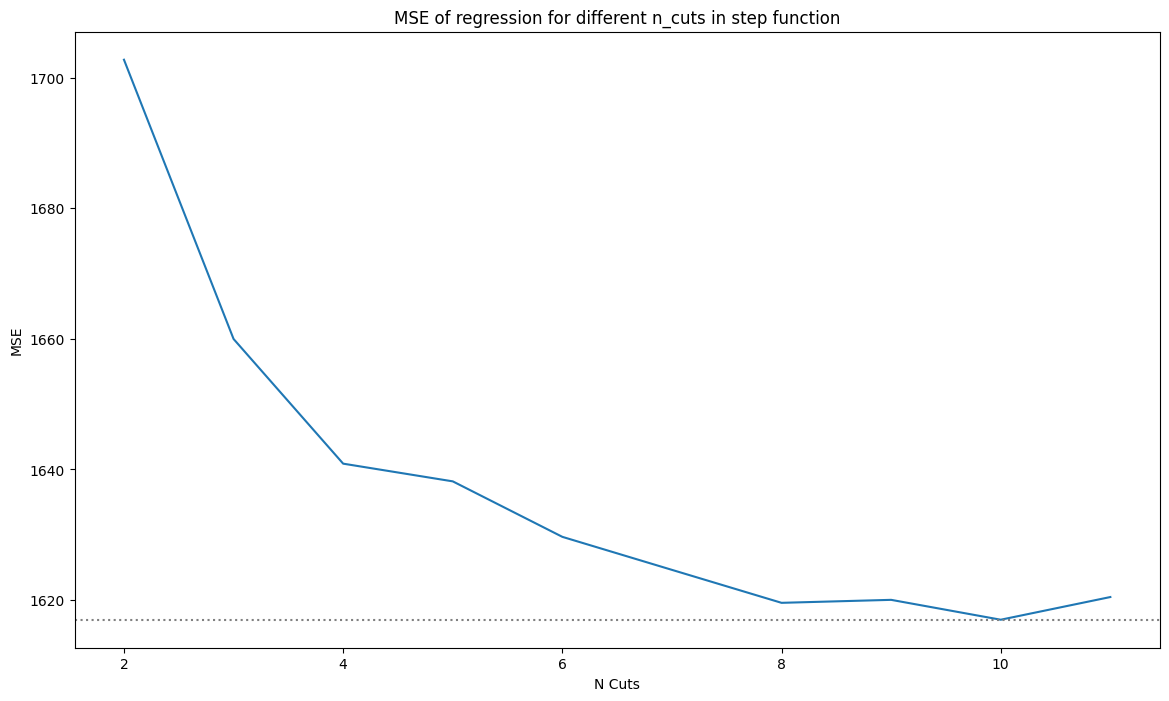

In [76]:
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot()
ax.plot(n_cuts, cv_scores)
ax.set_title('MSE of regression for different n_cuts in step function')
ax.set_xlabel('N Cuts')
ax.set_ylabel('MSE')
ax.axhline(min(cv_scores), ls=':', c='grey')

In [91]:
cuts_8_preds = pd.get_dummies(pd.cut(age, 8))
cuts_8_model = LinearRegression(fit_intercept=False).fit(cuts_8_preds, wage)

cuts_8_model.coef_

array([ 76.28175472, 102.11504564, 116.50743565, 119.78287854,
       116.41758335, 120.38418272, 105.22999975,  91.50593568])

In [117]:
intervals = cuts_8_preds.columns
list(intervals)

[Interval(17.938, 25.75, closed='right'),
 Interval(25.75, 33.5, closed='right'),
 Interval(33.5, 41.25, closed='right'),
 Interval(41.25, 49.0, closed='right'),
 Interval(49.0, 56.75, closed='right'),
 Interval(56.75, 64.5, closed='right'),
 Interval(64.5, 72.25, closed='right'),
 Interval(72.25, 80.0, closed='right')]

In [118]:
cuts_8_step_func = np.zeros_like(age_range, dtype=float)

In [120]:
for i, interval in enumerate(intervals):
    cuts_8_step_func += (((age_range >= interval.left) & (age_range < interval.right)) * cuts_8_model.coef_[i])

cuts_8_step_func

array([ 76.28175472,  76.28175472,  76.28175472,  76.28175472,
        76.28175472,  76.28175472,  76.28175472,  76.28175472,
       102.11504564, 102.11504564, 102.11504564, 102.11504564,
       102.11504564, 102.11504564, 102.11504564, 102.11504564,
       116.50743565, 116.50743565, 116.50743565, 116.50743565,
       116.50743565, 116.50743565, 116.50743565, 116.50743565,
       119.78287854, 119.78287854, 119.78287854, 119.78287854,
       119.78287854, 119.78287854, 119.78287854, 116.41758335,
       116.41758335, 116.41758335, 116.41758335, 116.41758335,
       116.41758335, 116.41758335, 116.41758335, 120.38418272,
       120.38418272, 120.38418272, 120.38418272, 120.38418272,
       120.38418272, 120.38418272, 120.38418272, 105.22999975,
       105.22999975, 105.22999975, 105.22999975, 105.22999975,
       105.22999975, 105.22999975, 105.22999975,  91.50593568,
        91.50593568,  91.50593568,  91.50593568,  91.50593568,
        91.50593568,  91.50593568])

Text(0, 0.5, 'Wage')

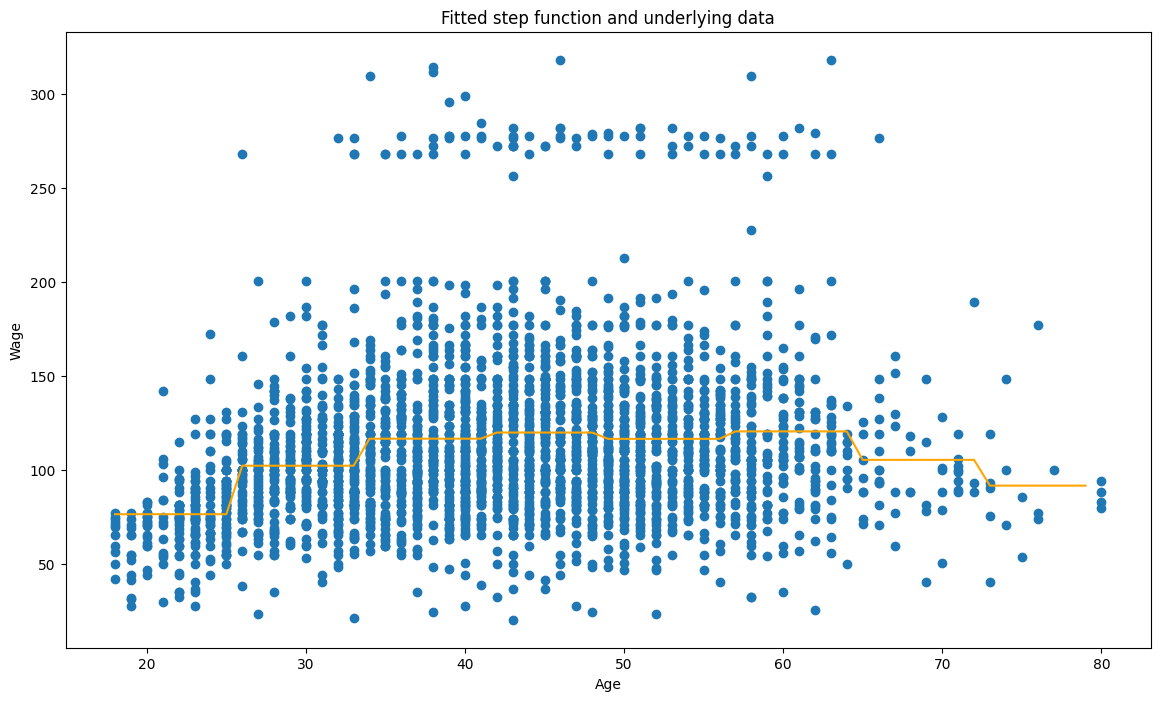

In [121]:
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot()
ax.scatter(age, wage)
ax.plot(age_range, cuts_8_step_func, c='orange')

ax.set_title('Fitted step function and underlying data')
ax.set_xlabel('Age')
ax.set_ylabel('Wage')
